---
title: "13.5 Case Study: Training a Neural Network"
subject:  Optimization
subtitle: the method to the madness
short_title: "13.5 Case Study: Training a Neural Network"
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: 
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/12_Ch_13_Optimization/144a-case-study-training-NN.ipynb)

[Original Pytorch walkthrough](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [14]:
# We need to install the required software packages for deep learning: this will take about 10min
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Learning Objectives

In the [preceding lecture](./144-SGD.ipynb), we were introduced to stochastic gradient descent as a computationally feasible alternative to a full backpropagation/gradient descent step. We then went through a whirlwind tour of how these principles can be applied all the way from traditional data science to modern deep learning. In this case study, we will focus on elucidating the main principles specifically behind training a neural network. By the end of this page, you should understand:
* How to load and divide up a large dataset
* The intuition behind various considerations for designing neural networks
* How to set-up a training loop for the neural network.

## The CIFAR-10 Dataset

In previous lectures and case studies, we have seen classifying handwritten digits as a recurring setting. This is largely due to historical importance and subsequent popularity of the [MNIST dataset](https://yann.lecun.com/exdb/mnist/), which was one of the key domino pieces leading to the current deep learning boom. The MNIST dataset has some nice properties: the data is rather clean and unambiguous for humans, leaving designing performant models as the main challenge to get computers to perform comparably (if not better). For this same reason, a dataset of comparable importance to MNIST in deep learning is the [CIFAR-10/100](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute For Advanced Research) dataset.

In particular, CIFAR-10 like MNIST is comprised of small, labelled images belonging to one of 10 classes. Whereas in MNIST these 10 classes were the 10 digits, the 10 classes of CIFAR-10 are various real-world things: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'. The classification task is therefore harder than in MNIST, since the photos are generally more "in the wild", more diverse within each class (think of all the breeds of dogs!), and are representations of 3-D objects, rather than 2-D writing.

Let's start by loading the data using the convenient `torchvision` package. Recall that we want to set aside a test set that is disjoint to the training set in order to evaluate the performance of our final model. For CIFAR-10, the training set contains 50000 images divided equally across tasks, while the test set contains 10000 images.

In [16]:
# normalizing transform to send values in [0,1] to [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


To get an idea of the task at hand, let's take a look at some sample images from the dataset.

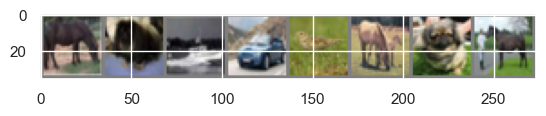

horse dog   ship  car   bird  horse dog   horse


In [17]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

As one can see, the images in CIFAR-10 are quite grainy (32x32 pixels), so one can imagine labeling some of these images can be hard even for humans! A statistic to keep in mind is that the average human performance on CIFAR-10 is estimated to be [around 94%](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html).

## An Appropriate Neural Network Architecture

Having loaded and perused the data, we now need to determine the model we'll use for our classifier. In class, we discussed the Multi-Layer Perception (MLP) as a backbone model in deep learning. As a quick review, an $L$-layer MLP is a composition of $L$ affine transformations interleaved with a fixed, non-linear transformation $\sigma(\cdot)$:
\begin{align*}
\vv h_1 &= \sigma(W_1 \vv x + \vv b_1) \\
\vv h_2 &= \sigma(W_2 \vv h_1 + \vv b_2) \\
&\vdots \\
\vv h_L &= \sigma(W_L \vv h_{L-1} + \vv b_L) \\
\vv o &= W_{L+1} \vv h_L + \vv b_{L+1}
\end{align*}
We recall the "learnable" parameters in an MLP are the parameters of the affine tranformation $(W_1, \bold b_1), \cdots (W_{L+1}, \bold b_{L+1})$.

:::{figure}../figures/14-3_mlp.jpg
:label:3_mlp
:alt:3_mlp
:width: 300px
:align: center
:::

While incredibly versatile, naively applying MLPs on their own turn out to be suboptimal for classifying images for various reasons, with the following as a primary reason. To pass an image through an MLP, it is flattened (a.k.a. vectorized) from a 2-D image (with 3 color channels) into a long vector. In the case of CIFAR-10, this turns into a $32\times 32 \times 3 = 3072$-dimensional input. A fully-connected MLP would then define a weight matrix mapping this $3072$-dimensional vector into the next hidden layer. However, as humans we understand images often have local structure, e.g. most pixels are similar to the ones around them. This local structure is completely ignored by an MLP, which connects every input element to every neuron in the next layer. This causes MLPs on image recognition to suffer various issues, including:
* **Parameter inefficiency**: for most in-the-wild images, *most* pixels that are far away from each other often have little relevance to each other. Therefore, a *fully-connected* MLP may introduce many more weights than necessary.
* **Sensitivity to translation**: as humans, moving an object within the image frame does not affect our prediction. This is known as "translation invariance". However, shifting an object makes it a completely different image to an MLP, and an MLP does not naturally encode this invariance. Therefore, an MLP can take a long time to reach satisfactory performance, and often remains brittle to otherwise very benign changes to an image.

This motivates a new type of neural network that addresses these issues unique to images. Enter: the Convolutional Neural Network (CNN). The CNN was designed precisely to address the above issues with standard MLPs. At the highest level, a CNN contains the following three types of layers:
1. *Convolutional* layer: filters patches of nearby pixels in a sliding window (where "convolution" comes from) and maps them to intermediate features.
2. *Pooling* layer: *downsamples* patches of pixels/features, e.g. sending a 2x2 patch to a single value. The value taken can either be the maximum of the downsampled patch ("max pooling") or the average ("average pooling").
3. Fully-connected layer (read: standard MLP). Once the features are of satisfactorily low-dimension after enough CNN and pooling layers, the features are flattened and MLP layers can be applied to produce the final output.

:::{figure}./144a-training-NN/CNN_layers.png
:label:conv_pooling_layers
:alt:conv_pooling_layers
:width: 50%
:align: center
A visualization of convolutional and pooling layers for a 2D input. The "convolutional kernel" is slid across the 2D input to output 2D features. The max pool layer then downsamples the 2D features by taking the max value of each patch.
:::

A standard CNN usually comprises of interleaved convolutional and pooling layers, followed by a sequence of fully-connected layers to produce the final output. The learnable parameters of the CNN are contained in the convolutional layers' filter parameters as well as the MLP layers.
:::{note}
The fact that the filter parameters are *learned* is what sets CNNs apart from traditional image processing methods, where filters are designed manually, such as [Gabor](https://www.mathworks.com/help/images/ref/gabor.html) or [Gaussian](https://reference.wolfram.com/language/ref/GaussianFilter.html) filters.
:::

:::{figure}./144a-training-NN/CNN.jpg
:label:CNN
:alt:CNN
:width: 50%

A cartoon of a simple CNN from input to output.
:::

### What exactly is a convolution?

We introduce the mathematical basis for convolutional layers. We won't sweat too much on the practical details, which are more appropriate for a deep learning course like ESE 5460. From the graphics above, one can gather that a convolution layer passes a filter (read: matrix) over sliding patches of the input and produces a (usually) smaller output.
:::{figure}./144a-training-NN/CNN-filter-animation.gif
:label:conv_layer
:alt:conv_layer
:width: 50%
:::
:::{figure}./144a-training-NN/edge_detect.webp
:label:edge_sharpening
:alt:edge_sharpening
:width: 50%
:::
A convolutional filter involves a few key parameters:
1. **Filter size**: the filter size determines how large a patch is considered at once, e.g. $3\times 3$ in the above graphic.
2. **Stride**: stride determines the step-size with which the filter moves across the input. A stride of 1 means the filter moves across the image one pixel at time, while 2 means the filter skips every other pixel. The stride of the above gif is $1$, for example.
3. **Padding**: padding determines how the filter behaves at the edges of the image. For example, usually the corner pixels of the image can't fit a filter, since imposing filter exceeds the bounds of the image. *Valid padding* (or "no padding") means any pixel that can't fit the filter is skipped like in the above gif, whereas *same padding* pads any out-of-bounds pixels of the filter with a dummy value (usually $0$). Since *valid padding* means the filter can't be applied to edge pixels (more severe the larger the filter), the output is guaranteed to be smaller, whereas *same padding* can ensure the output stays the same size as the input.

Now onto the math. Let's consider a 2D image that is $n \times n$ pixels (no third color dimension!), and a convolutional filter of size $k \times k$, `stride = 1`, `padding = 'valid'`:
\begin{align*}
\mathrm{Input} &= X \in \R^{N \times N} \\
\mathrm{Filter} &= K \in \R^{K \times K}.
\end{align*}
Then the elements of the linear convolution (denoted by $\ast$) between $X$ and $K$ is:
\begin{align*}
    (X \ast K)_{i,j}
    &= \sum_{p=1}^k \sum_{q=1}^k K_{p,q} X_{i+p, j+q}
\end{align*}

```{exercise}
:label: conv_linear

Convince yourself the convolution operator $\ast$ is **bi-linear**. That is, holding either argument fixed, it is a linear map.
```


Intuitively, each pixel in the output is the dot-product between the filter and the corresponding patch of the input image. To complete the convolutional layer and make it a deep learning object, we simply add a bias $B$ and entrywise nonlinearity $\sigma(\cdot)$:
\begin{align*}
    \mathrm{Output} = Y &= \sigma(X \ast K + B) \in \R^{(n-2k) \times (n-2k)}.
\end{align*}
The learnable parameters of a convolutional layer are therefore $(K,B)$.

We can also demonstrate the parameter efficiency of convolutional layers. The dimension of the conv layer parameters $(K,B)$ are:
\begin{align*}
    (K,B): k \times k + (n-2k)\times (n-2k) = 5k^2 - 4nk + n^2 \approx n^2  \text{ parameters}
\end{align*}
If we had used a fully-connected MLP layer to map between the $n \times n$ input and $(n-2k)\times (n-2k)$ output, we come to a parameter count of 
\begin{align*}
    (W_{\mathrm{MLP}}, b_{\mathrm{MLP}}) \to n^2 \times (n-2k)^2 + (n-2k)^2 \approx n^4 \text{ parameters},
\end{align*}
which is orders of magnitude more parameters than the conv layer. Even for the modest $32\times 32$ pixel CIFAR-10 images, this computes to $1024\times$ more parameters (not even considering the RGB depth dimension).

## Let it loose!

Now that we understand the fundamental mechanisms and benefits of a convolutional layer for vision/image-related tasks, let's try it out! Fortunately for us, smart people have done the numerical heavylifting and made it very easy to build a CNN. Let's construct a CNN composed of two iterations of convolution and pooling, followed by a two-layer MLP to bring us to the final output.

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

We now designate what loss and optimization algorithm to use. We will use the cross-entropy loss, which is a standard choice for multi-class classification problems, and stochastic gradient descent for the optimization algorithm. SGD takes two user-set **hyperparameters**: the *learning rate* (i.e. the step size) and *momentum*. Momentum determines to what extent we commit to the stochastic gradient direction. For example, if $\theta^{(k)}$ denotes our parameters at iteration $k$ and $d^{(k)}$ denotes the stochastic gradient direction, no momentum would yield
\begin{align*}
\theta^{(k+1)} = \theta^{(k)} - \eta d^{(k)},
\end{align*}
i.e. fully following the stochastic gradient. A momentum parameter of $\alpha \in (0,1)$ instead yields
\begin{align*}
\theta^{(k+1)} = \theta^{(k)} - \eta[\alpha \theta^{(k)} +  (1 - \alpha) d^{(k)}],
\end{align*}
in other words the previous iterate carries some "momentum". Momentum is essential in machine learning contexts where the small batches relative to the dataset can yield highly stochastic iterates, preventing a model from committing too hard to a bad draw of SGD.

We won't worry too much about the details behind cross-entropy loss, beyond the fact that penalizes predicting the wrong label.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Having defined our loss criterion and optimizer, we are almost ready to train our model. We now describe the essential ingredients of the training loop. The first moving part is the number of *epochs*, which is the number of times we want to iterate over the full training set when training the model.

Within each epoch, we perform the following sequence of operations iteratively:
1. Sample a new mini-batch of (images, labels)
2. Set the gradient from last iteration to zero
3. Pass the inputs through our current model
4. Compute the loss between the labels and the model outputs
5. Accumulate the stochastic gradient via backpropagation
6. Perform a model update via SGD (with momentum)

We are ready to run our first training loop.

In [20]:
num_epoch = 10
losses = []
for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # pass data through our network
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # backpropagation is computed here
        optimizer.step() # network is updated here

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[epoch 1, batch  2000] loss: 2.214
[epoch 1, batch  4000] loss: 1.772
[epoch 1, batch  6000] loss: 1.626
[epoch 2, batch  2000] loss: 1.516
[epoch 2, batch  4000] loss: 1.435
[epoch 2, batch  6000] loss: 1.376
[epoch 3, batch  2000] loss: 1.304
[epoch 3, batch  4000] loss: 1.275
[epoch 3, batch  6000] loss: 1.237
[epoch 4, batch  2000] loss: 1.168
[epoch 4, batch  4000] loss: 1.163
[epoch 4, batch  6000] loss: 1.143
[epoch 5, batch  2000] loss: 1.072
[epoch 5, batch  4000] loss: 1.074
[epoch 5, batch  6000] loss: 1.074
[epoch 6, batch  2000] loss: 1.000
[epoch 6, batch  4000] loss: 1.012
[epoch 6, batch  6000] loss: 1.013
[epoch 7, batch  2000] loss: 0.939
[epoch 7, batch  4000] loss: 0.958
[epoch 7, batch  6000] loss: 0.972
[epoch 8, batch  2000] loss: 0.894
[epoch 8, batch  4000] loss: 0.904
[epoch 8, batch  6000] loss: 0.924
[epoch 9, batch  2000] loss: 0.846
[epoch 9, batch  4000] loss: 0.867
[epoch 9, batch  6000] loss: 0.878
[epoch 10, batch  2000] loss: 0.815
[epoch 10, batch  4

Let's plot the training loss of our model over the iterations of SGD.

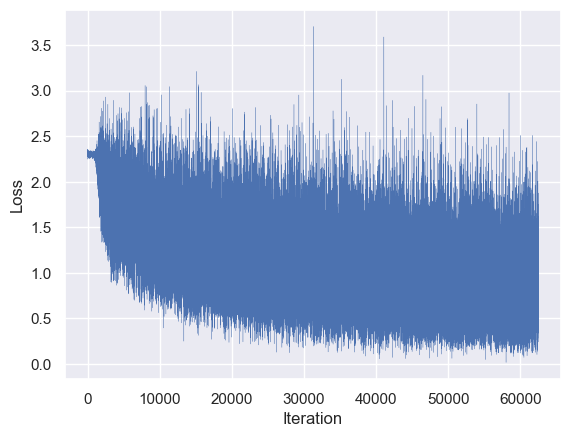

In [21]:
plt.plot(np.arange(len(losses)), losses, linewidth=0.2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Whoa Nelly! This becomes a familiar sight when doing deep learning. If you were wondering how optimizing over a model that is so explicitly non-convex and stochastic could be possible, it doesn't come without its own hazards--as seen here, the loss can be very sensitive to small changes in the parameters. However, there is a clear overall trend down.

More importantly, did it learn anything useful? Let's compute the accuracy attained on the *test set*.

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the largest entry is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


Though a far cry from the human-tier of accuracy at 94%, our basic CNN does markedly better than the 10% for guessing at random! We also note that we used a small number of epochs for this demonstration, and the performance would likely improve if we had let our model train for longer.

Let's take a peek at our model's performance across the different classes.

In [23]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.8 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 51.3 %
Accuracy for class: cat   is 55.0 %
Accuracy for class: deer  is 66.1 %
Accuracy for class: dog   is 29.0 %
Accuracy for class: frog  is 70.1 %
Accuracy for class: horse is 74.3 %
Accuracy for class: ship  is 69.5 %
Accuracy for class: truck is 79.3 %


And now for further visualization through our favorite confusion matrix.

In [24]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

cf = np.zeros((10,10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        cf += confusion_matrix(labels.numpy(), predictions.numpy(), labels=np.arange(10))
# normalize to [0,1]
cf = cf / np.sum(cf, axis=1)[:, None]

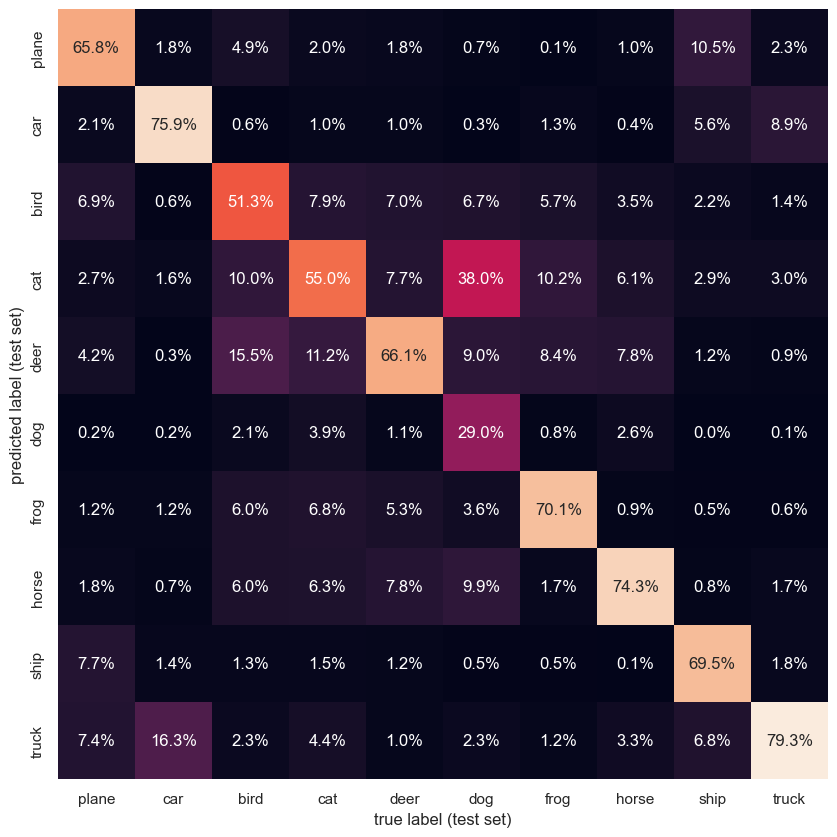

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(cf.T, square=True, annot=True, fmt = ".1%", cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label (test set)')
plt.ylabel('predicted label (test set)')
plt.show()

Somewhat predictably, our CNN encounters the highest confusion when distinguishing between the various mammals.